In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('sample_submission.csv')

In [ ]:
trainX = train.drop('label', axis=1).astype('float32')
trainY = train['label']
testX = test.astype('float32')

In [ ]:
trainX = torch.tensor(trainX.values, dtype=torch.float32)
trainY = torch.tensor(trainY.values)
testX = torch.tensor(testX.values, dtype=torch.float32)

In [ ]:
trainX = trainX / 255.0
testX = testX / 255.0

In [ ]:
trainX, validX, trainY, validY = train_test_split(trainX, trainY, test_size=0.2, random_state=42)
trainX = trainX.reshape(-1,28,28).unsqueeze(dim=1)
validX = validX.reshape(-1,28,28).unsqueeze(dim=1)
testX = testX.reshape(-1,28,28).unsqueeze(dim=1)

In [ ]:
print(trainX.shape)
print(validX.shape)
print(trainY.shape)
print(validY.shape)
print(testX.shape)

torch.Size([33600, 1, 28, 28])
torch.Size([8400, 1, 28, 28])
torch.Size([33600])
torch.Size([8400])
torch.Size([28000, 1, 28, 28])


In [ ]:
from torch.utils.data import TensorDataset
train_dataset = TensorDataset(trainX, trainY)
valid_dataset = TensorDataset(validX, validY)
test_dataset = TensorDataset(testX)

In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
valid_dataloader = DataLoader(dataset=valid_dataset,
                              batch_size = BATCH_SIZE,
                              shuffle=True)

In [ ]:
img, label=next(iter(train_dataloader))
print(f"The shape of the images is : {img.shape}")

The shape of the images is : torch.Size([32, 1, 28, 28])


In [ ]:
class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
    self.relu1 = nn.ReLU()
    self.maxpool1 = nn.MaxPool2d(kernel_size=2)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
    self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
    self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
    self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(12544, 512)
    self.fc2 = nn.Linear(512, 10)
    self.dropout1 = nn.Dropout(0.3)
    self.dropout2 = nn.Dropout(0.35)
    self.dropout3 = nn.Dropout(0.5)

  def dynamicLinear(x, output_size):
    return 1

  def forward(self, x):
    x = self.conv1(x)
    x = self.relu1(x)
    x = self.conv2(x)
    x = self.relu1(x)
    x = self.maxpool1(x)
    x = self.dropout1(x)
    x = self.conv3(x)
    x = self.relu1(x)
    x = self.conv4(x)
    x = self.relu1(x)
    x = self.maxpool1(x)
    x = self.dropout1(x)
    x = self.conv5(x)
    x = self.relu1(x)
    x = self.conv6(x)
    x = self.relu1(x)
    x = self.dropout2(x)
    x = self.flatten(x)
    x = self.fc1(x)
    x = self.relu1(x)
    x = self.dropout3(x)
    x = self.fc2(x)
    return x

In [ ]:
import torch.optim as optim

model = Model()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def train(model, dataloader, criterion, optimizer):
  model.train()
  running_loss = 0.0
  correct = 0
  total = 0

  for images, labels in dataloader:
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    _, predicted = torch.max(outputs.data, 1)
    running_loss += loss.item()
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  train_loss = running_loss / len(dataloader)
  train_acc = (correct / total) * 100
  return train_loss, train_acc

In [ ]:
import matplotlib.pyplot as plt
def evaluate(model, dataloader, criterion):
  model.eval()
  running_loss = 0.0
  correct = 0
  total = 0

  with torch.no_grad():
    for images, labels in dataloader:
      outputs = model(images)
      loss = criterion(outputs, labels)

      _, predicted = torch.max(outputs.data, 1)

      running_loss += loss.item()
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  test_loss = running_loss / len(dataloader)
  test_acc = (correct / total) * 100
  return test_loss, test_acc

In [ ]:
epochs = 10

for epoch in range(epochs):
    train_loss, train_acc = train(model, train_dataloader, criterion, optimizer)
    test_loss, test_acc = evaluate(model, valid_dataloader, criterion)

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} - Train Accuracy: {train_acc:.2f}%")
    print(f"Test Loss: {test_loss:.4f} - Test Accuracy: {test_acc:.2f}%")


Epoch 1/10
Train Loss: 0.3652 - Train Accuracy: 87.86%
Test Loss: 0.0765 - Test Accuracy: 97.70%


KeyboardInterrupt: ignored

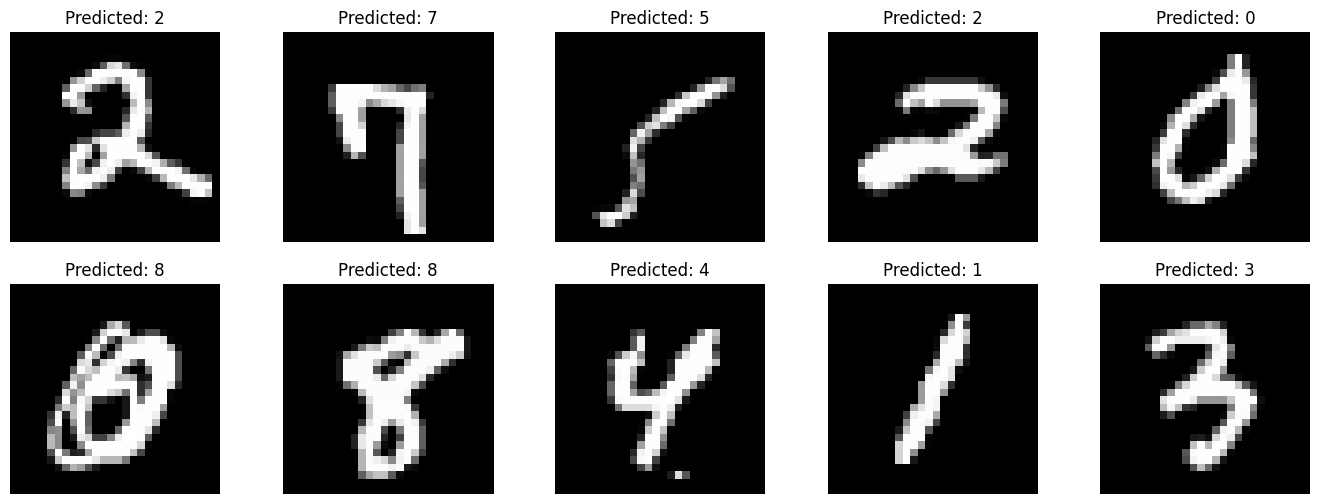

In [ ]:
model.eval()
import random
with torch.inference_mode():
  test_preds = model(testX)
  _, predicted_labels = torch.max(test_preds, dim=1)

  num_samples = 10
  random_indices = random.sample(range(len(testX)), num_samples)
  fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(17,6))

  for i, idx in enumerate(random_indices):
    image = testX[idx].squeeze().numpy()
    predicted_labels_string = str(predicted_labels[idx].item())

    ax[i // 5, i % 5].imshow(image, cmap='gray')
    ax[i // 5, i % 5].set_title('Predicted: ' + predicted_labels_string)
    ax[i // 5, i % 5].axis('off')
plt.show()

In [ ]:
submission_df = pd.DataFrame({'ImageId': range(1, len(predicted_labels) + 1),
                              'Label': predicted_labels})
submission_df

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


In [ ]:
submission_df.to_csv('submission.csv',index=False)

In [1]:
# GPU 사용

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import random

# GPU 디바이스 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('sample_submission.csv')

trainX = train.drop('label', axis=1).astype('float32')
trainY = train['label']
testX = test.astype('float32')

trainX = torch.tensor(trainX.values, dtype=torch.float32).to(device)
trainY = torch.tensor(trainY.values).to(device)
testX = torch.tensor(testX.values, dtype=torch.float32).to(device)

trainX = trainX / 255.0
testX = testX / 255.0

trainX, validX, trainY, validY = train_test_split(trainX, trainY, test_size=0.2, random_state=42)
trainX = trainX.reshape(-1, 28, 28).unsqueeze(dim=1).to(device)
validX = validX.reshape(-1, 28, 28).unsqueeze(dim=1).to(device)
testX = testX.reshape(-1, 28, 28).unsqueeze(dim=1).to(device)

print(trainX.shape)
print(validX.shape)
print(trainY.shape)
print(validY.shape)
print(testX.shape)

train_dataset = TensorDataset(trainX, trainY)
valid_dataset = TensorDataset(validX, validY)
test_dataset = TensorDataset(testX)

BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE, shuffle=True)

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(12544, 512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout1 = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.35)
        self.dropout3 = nn.Dropout(0.5)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.dropout1(x)
        x = self.conv3(x)
        x = self.relu1(x)
        x = self.conv4(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.dropout1(x)
        x = self.conv5(x)
        x = self.relu1(x)
        x = self.conv6(x)
        x = self.relu1(x)
        x = self.dropout2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout3(x)
        x = self.fc2(x)
        return x

model = Model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        running_loss += loss.item()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(dataloader)
    train_acc = (correct / total) * 100
    return train_loss, train_acc

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            running_loss += loss.item()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss = running_loss / len(dataloader)
    test_acc = (correct / total) * 100
    return test_loss, test_acc

epochs = 30

for epoch in range(epochs):
    train_loss, train_acc = train(model, train_dataloader, criterion, optimizer, device)
    test_loss, test_acc = evaluate(model, valid_dataloader, criterion, device)

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} - Train Accuracy: {train_acc:.2f}%")
    print(f"Test Loss: {test_loss:.4f} - Test Accuracy: {test_acc:.2f}%")



torch.Size([33600, 1, 28, 28])
torch.Size([8400, 1, 28, 28])
torch.Size([33600])
torch.Size([8400])
torch.Size([28000, 1, 28, 28])
Epoch 1/30
Train Loss: 0.7411 - Train Accuracy: 73.03%
Test Loss: 0.0815 - Test Accuracy: 97.38%
Epoch 2/30
Train Loss: 0.1197 - Train Accuracy: 96.40%
Test Loss: 0.0556 - Test Accuracy: 98.30%
Epoch 3/30
Train Loss: 0.0897 - Train Accuracy: 97.46%
Test Loss: 0.0509 - Test Accuracy: 98.51%
Epoch 4/30
Train Loss: 0.0729 - Train Accuracy: 97.87%
Test Loss: 0.0550 - Test Accuracy: 98.45%
Epoch 5/30
Train Loss: 0.0711 - Train Accuracy: 97.96%
Test Loss: 0.0395 - Test Accuracy: 98.83%
Epoch 6/30
Train Loss: 0.0618 - Train Accuracy: 98.18%
Test Loss: 0.0386 - Test Accuracy: 98.81%
Epoch 7/30
Train Loss: 0.0569 - Train Accuracy: 98.34%
Test Loss: 0.0344 - Test Accuracy: 98.90%
Epoch 8/30
Train Loss: 0.0534 - Train Accuracy: 98.43%
Test Loss: 0.0393 - Test Accuracy: 98.83%
Epoch 9/30
Train Loss: 0.0527 - Train Accuracy: 98.45%
Test Loss: 0.0399 - Test Accuracy: 98.

In [34]:
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

with torch.no_grad():
    predicted_labels = []

    for images in test_dataloader:
        images = images[0].to(device)

        # 모델 예측
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        # 예측된 레이블 저장
        predicted_labels.extend(predicted.cpu().tolist())

# 시각화 및 제출 파일 생성 코드 생략

submission_df = pd.DataFrame({'ImageId': range(1, len(predicted_labels) + 1),
                             'Label': predicted_labels})
submission_df.to_csv('submission.csv', index=False)

In [35]:
submission_df

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9
